# Deteção da malária através de imagens de células

## Objectivo

O objectivo é de criar um modelo com a deep learning que pode ser usado para facilitar do médico especialista ao verificar se o doente tem ou não malária através de images.

O deve ser modelo capaz de distinguir entre duas classes fundamentais:

> - Células não infectadas (Uninfected): Glóbulos vermelhos saudáveis sem infeção por malária.
> - Células Parasitadas (Parasitized ): Glóbulos vermelhos infectados com parasitas Plasmodium.

Isto requer que o modelo atinja uma acúracia de pelos 85% ou mais e tenha uma boa precisão.

### 1. Importar as bibliotecas necessarias

In [3]:
# importaçao das Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import PIL

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"

import warnings
warnings.filterwarnings('ignore')
import pathlib

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

import tensorflow as tf
import tensorflow as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.callbacks import ReduceLROnPlateau
from keras.applications import MobileNetV2
from tensorflow.keras.regularizers import l2
%matplotlib inline

### 1.1 Exploração de Dados

In [4]:
data_dir = pathlib.Path('cell_images').with_suffix('')

In [5]:
# contar o numero de imagens
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count," imagens")

27558  imagens


In [6]:
naoInfectada = list(data_dir.glob("Uninfected/*"))
infectada = list(data_dir.glob("Parasitized/*"))
print("Número de células não infectadas: ", len(naoInfectada))
print("Número de células infectadas: ", len(infectada))

Número de células não infectadas:  13780
Número de células infectadas:  13780


#### Mostrar alguns exemplos

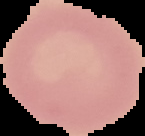

In [7]:
PIL.Image.open(naoInfectada[1])

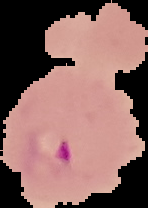

In [8]:
PIL.Image.open(infectada[1])

### 2. Carregar as imagens de treino e o dataset de validacao

#### i. Carregar as imagens do datase e aplicaco aumentacao

In [9]:
BATCH_SIZE=32
IMG_HEIGHT=150
IMG_WIDTH=150

In [10]:
# aumentacao...imagens e classes que pertencem
image_gen = ImageDataGenerator(
    rotation_range=40,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.3,
    rescale=1/255
)

In [11]:
# Carregar dataset de treino e validacao
training_data = image_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    subset = "training",
    class_mode="binary",
)

validation_data = image_gen.flow_from_directory(
    data_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    subset = "validation",
    class_mode="binary",
)


Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


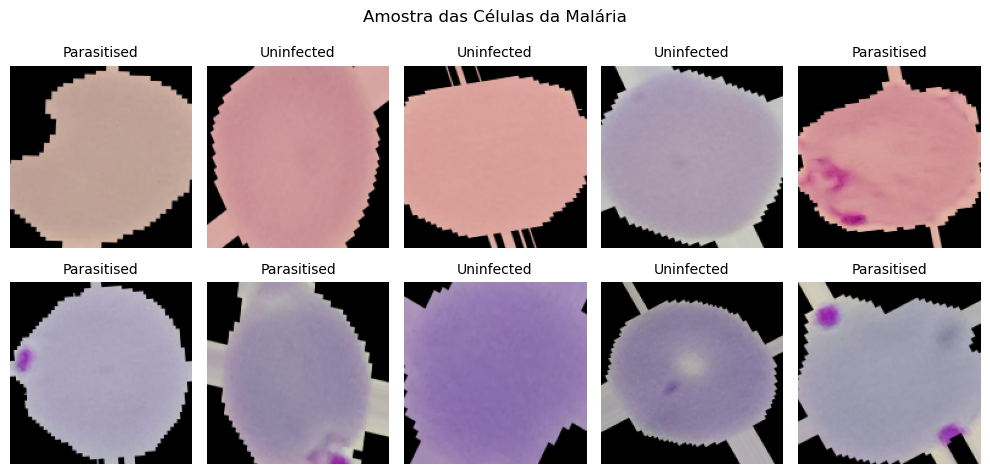

In [12]:
X_train, y_train = next(training_data)

fig = plt.figure(figsize=(10, 5))

for i in range(10):
    ax = fig.add_subplot(2, 5, i+1)
    ax.imshow(X_train[i])
    ax.axis("off")
    ax.set_title("Uninfected" if y_train[i] == 1 else "Parasitised", fontsize=10)
fig.suptitle("Amostra das Células da Malária")
plt.tight_layout()
plt.savefig("Amostra das Células da Malária.png")

In [13]:
train_steps = np.ceil(training_data.samples // training_data.batch_size)
val_steps = np.ceil(validation_data.samples / validation_data.batch_size)
print(train_steps)
print(val_steps)

602.0
259.0


#### ii. Pegar as labels de mapeamento

In [14]:
labels={value:key for key, value in training_data.class_indices.items()}

print("Mapeamento das Labels para classes presente no dataset de treino e validacao\n")
for key, value in labels.items():
    print(f"{key}:{value}")

Mapeamento das Labels para classes presente no dataset de treino e validacao

0:Parasitized
1:Uninfected


### 3. Treinar o Modelo

#### i. Criar o modelo

In [15]:
def create_model():
    # include_top=False remove a camada de classificação
    base_model = MobileNetV2(weights='mobilenet_v2_1.0_224_no_top.h5', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    #model.add(Dense(len(labels), activation='softmax'))
    model.add(Dense(1, activation='sigmoid'))  # 1 neurônio para classificação binária
    
    return model

In [16]:
cnn_model=create_model()

In [17]:
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_150 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________
None


#### ii. Definindo callbacks

In [18]:
#reduzir a taxa de aprendizagem com Plateau.
#Reduzir a taxa de aprendizagem quando as metricas param de melhorar.
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=7) 

#### iii. Definindo o optmizador

In [19]:
optimizer=Adam(learning_rate=0.0001)

#### iv. Compilar o modelo

In [20]:
cnn_model.compile(optimizer=optimizer,loss=BinaryCrossentropy(),metrics=['accuracy'])

#### v. Treinar o modelo

In [21]:
history = cnn_model.fit(
    training_data, 
    epochs=5,
    steps_per_epoch=training_data.samples//BATCH_SIZE,
    validation_data=validation_data,
    verbose=1, 
    callbacks=[reduce_lr])


Epoch 1/5
602/602 [==============================] - 806s 1s/step - loss: 0.3924 - accuracy: 0.8299 - val_loss: 0.2800 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 2/5
602/602 [==============================] - 633s 1s/step - loss: 0.2637 - accuracy: 0.9012 - val_loss: 0.2447 - val_accuracy: 0.9089 - lr: 1.0000e-04
Epoch 3/5
602/602 [==============================] - 854s 1s/step - loss: 0.2400 - accuracy: 0.9090 - val_loss: 0.2311 - val_accuracy: 0.9154 - lr: 1.0000e-04
Epoch 4/5
602/602 [==============================] - 713s 1s/step - loss: 0.2276 - accuracy: 0.9154 - val_loss: 0.2263 - val_accuracy: 0.9153 - lr: 1.0000e-04
Epoch 5/5
602/602 [==============================] - 727s 1s/step - loss: 0.2217 - accuracy: 0.9175 - val_loss: 0.2213 - val_accuracy: 0.9198 - lr: 1.0000e-04


### 5. Traçar Gráfico das Métricas do Modelo

#### i. Traçar o gráfico da acurácia, perdas e taxa de aprendizagem no treino e validacao

In [22]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

learning_rate = history.history['lr']

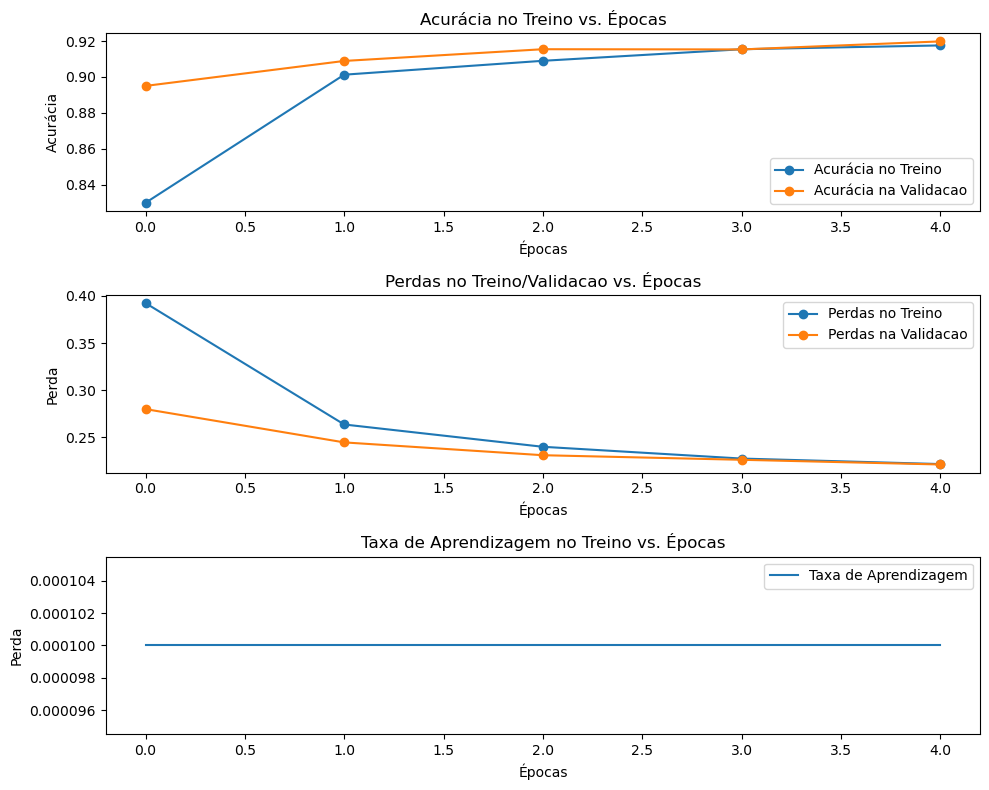

In [23]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
ax[0].set_title("Acurácia no Treino vs. Épocas")
ax[0].plot(train_accuracy, 'o-', label='Acurácia no Treino')
ax[0].plot(val_accuracy, 'o-', label='Acurácia na Validacao')
ax[0].set_xlabel('Épocas')
ax[0].set_ylabel('Acurácia')
ax[0].legend(loc='best')


ax[1].set_title("Perdas no Treino/Validacao vs. Épocas")
ax[1].plot(train_loss, 'o-', label='Perdas no Treino')
ax[1].plot(val_loss, 'o-', label='Perdas na Validacao')
ax[1].set_xlabel('Épocas')
ax[1].set_ylabel('Perda')
ax[1].legend(loc='best')


ax[2].set_title("Taxa de Aprendizagem no Treino vs. Épocas")
ax[2].plot(learning_rate, label='Taxa de Aprendizagem')
ax[2].set_xlabel('Épocas')
ax[2].set_ylabel('Perda')
ax[2].legend(loc='best')

plt.tight_layout()
plt.savefig("gráfico-da-acurácia-perdas-e-taxa-de-aprendizagem-no-treino-e-validacao-5-epocas-mobilenet.png")
plt.show()

In [24]:
#salvar o modelo para testes"
cnn_model.save("malaria-5-epochs-mobilenet.h5")

### 6. Modelo de Previsao no Dataset de Test

In [60]:
predictions=cnn_model.predict(validation_data)

259/259 [==============================] - 292s 1s/step


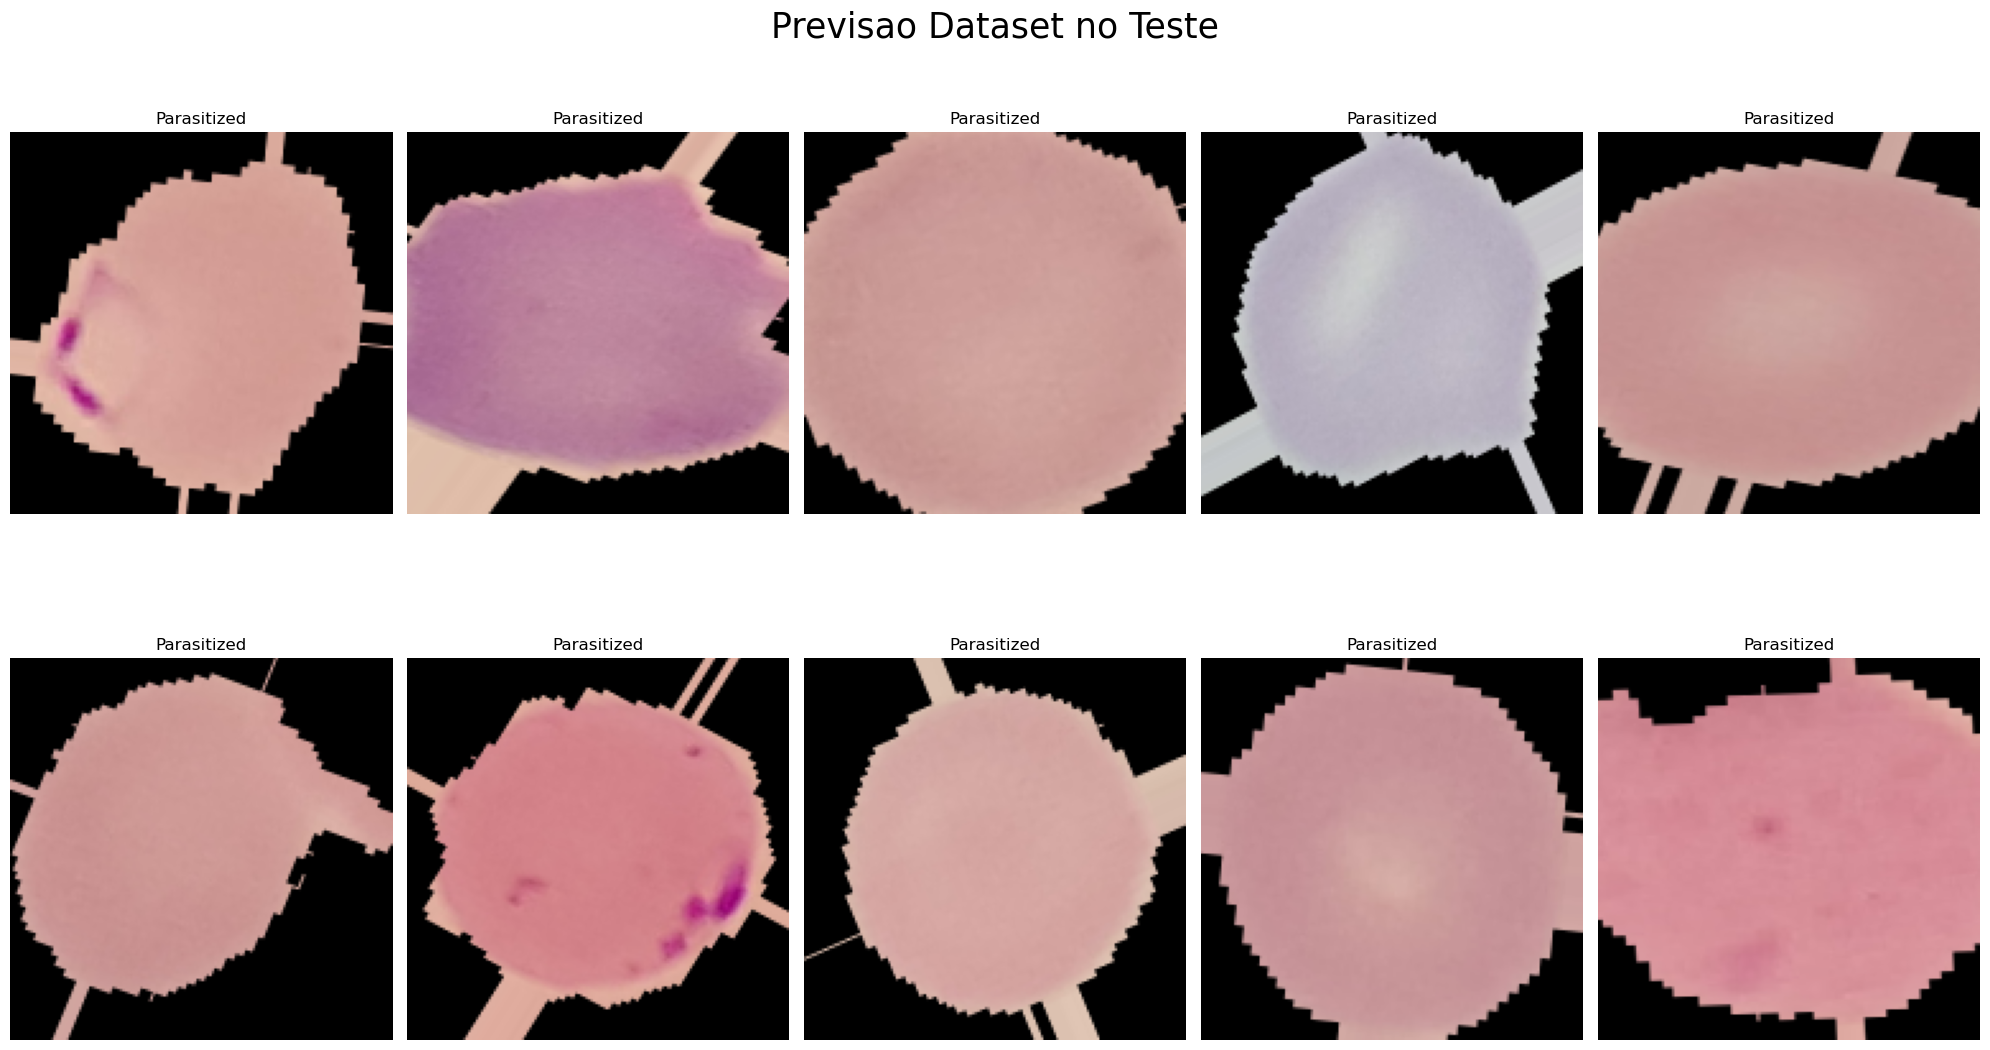

In [62]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(20, 12))
idx = 0

for i in range(2):
    for j in range(5):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(validation_data[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Previsao Dataset no Teste",fontsize=25)
plt.savefig("Previsao-Dataset-no-Teste-5-epocas-mobilenet.png")
plt.show()


In [30]:
test_loss,test_accuracy=cnn_model.evaluate(validation_data, batch_size=BATCH_SIZE)

259/259 [==============================] - 213s 819ms/step - loss: 0.2191 - accuracy: 0.9186


In [63]:
print(f"Perdas no teste: {test_loss}")
print(f"Acurária no teste: {test_accuracy}")

Perdas no teste: 0.21911421418190002
Acurária no teste: 0.9185821413993835


### 8. Traçando Gráfico das Metricas de Classificacao

#### i. Matriz de Confusao

In [64]:
y_pred = np.argmax(predictions, axis=1)
y_true = validation_data.classes

In [65]:
predicted_classes = np.round(predictions).flatten()

true_classes = validation_data.classes

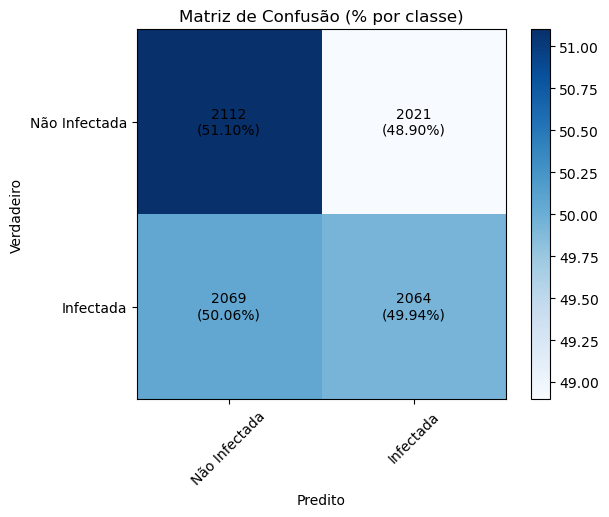

In [66]:
# Criando a matriz de confusão
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Calculando as percentagens em relação ao total de instâncias para cada classe
conf_matrix_percent = conf_matrix / np.sum(conf_matrix, axis=1, keepdims=True) * 100

# Visualizando a matriz de confusão com percentagens
plt.imshow(conf_matrix_percent, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de Confusão (% por classe)')
plt.colorbar()
classes = ['Não Infectada', 'Infectada']
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Adicionando as percentagens nas células da matriz
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, f'{conf_matrix[i, j]}\n({conf_matrix_percent[i, j]:.2f}%)', ha='center', va='center')

plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.savefig("matrix-de-confusao-5-epocas-mobilenet.png")
plt.show()

### Calcular a Curva ROC

In [67]:
# Obtendo as probabilidades de pertencer à classe positiva
probas = cnn_model.predict(validation_data)

# Calculando a curva ROC
fpr, tpr, thresholds = roc_curve(true_classes, probas)
roc_auc = auc(fpr, tpr)

# Visualizando a curva ROC
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.savefig("curva-roc-multiclass-5-epocas-mobilenet.png")
plt.show()

 58/259 [=====>........................] - ETA: 4:12

In [ ]:
# Exibir o relatório de classificação
print(classification_report(true_classes, predicted_classes))

              precision    recall  f1-score   support

           0       0.50      0.51      0.51      4133
           1       0.50      0.50      0.50      4133

    accuracy                           0.50      8266
   macro avg       0.50      0.50      0.50      8266
weighted avg       0.50      0.50      0.50      8266



### 9. Classificacoes Erradas

In [45]:
# vamos ver se o modelo classificou de forma errada
errors = (y_true-y_pred != 0)
y_true_errors = y_true[errors]
y_pred_errors = y_pred[errors]

In [46]:
test_images = validation_data.filenames
test_img = np.asarray(test_images)[errors]


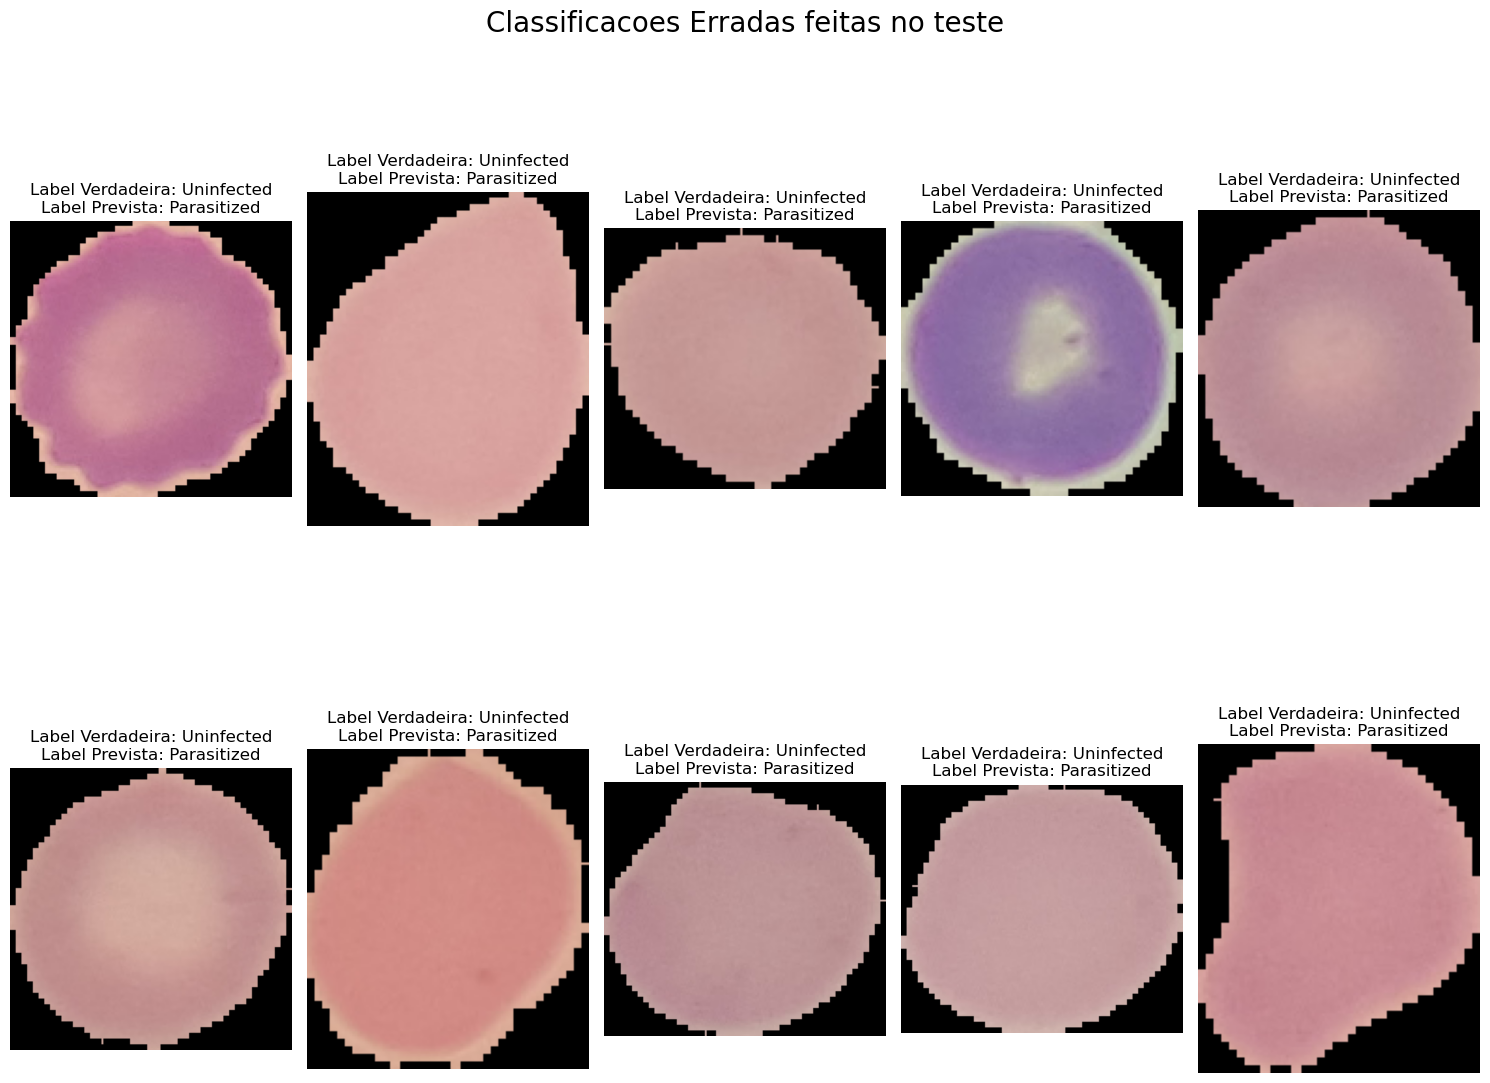

In [48]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 13))
idx = 0

for i in range(2):
    for j in range(5):
        idx = np.random.randint(0, len(test_img))
        true_index = y_true_errors[idx]
        true_label = labels[true_index]

        predicted_index = y_pred_errors[idx]
        predicted_label = labels[predicted_index]

        ax[i, j].set_title(f"Label Verdadeira: {true_label}\nLabel Prevista: {predicted_label}")
        img_path = os.path.join(data_dir, test_img[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i,j].imshow(img)
        ax[i,j].axis("off")

plt.tight_layout()
plt.suptitle("Classificacoes Erradas feitas no teste", fontsize=20)
plt.savefig("Classificacoes-Erradas-feitas-no-teste-5-epocas-mobilenet.png")
plt.show()

####